# Neural Networks Project - Gesture Recognition

### Group Members
1. Chethana Manyam
2. Jenifer Sam

### Problem Statement
As a data scientist working at a home electronics company which manufactures state of the art smart televisions, we want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Gesture	Corresponding Action
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like resizing and normalization should be performed.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. 

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

# Implementation

### Import Necessary Libraries

In [102]:
# Import necessary libraries

import os
import random as rn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import datetime

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from PIL import Image

We set the random seed so that the results don't vary drastically.

In [103]:
# Set random seed for Python operations (e.g., NumPy)
np.random.seed(30)
rn.seed(30)
# Set random seed for TensorFlow operations
tf.random.set_seed(30)

- Read the folder names for training and validation. 
- Set the batch_size. Note that the batch size is set in such a way that we are able to use the CPU in full capacity. We will keep increasing the batch size until the machine throws an error.

# Initialization
### 1. Initialize Folder Path

In [104]:
# Get the path where data is located
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
train_path = 'Project_data/train'
val_path =  'Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)

# Training sequences = 663
# Validation sequences = 100


### 2. Initialize Frame Properties
The dimensions of the frame are:
- dim_x - frame height
- dim_y - frame width

These values will then be played with in the experiments to look for better models.

In [13]:
# Initialize frame properties    
dim_x = 100
dim_y = 100
channels = 3 #RGB frames
num_classes = 5
total_frames = 30

### 3. Initialize Hyperparameters
- Batch size
- Frame count per video for training the model
- No. of epochs

These values will then be played with in experiments to improve the base model.

In [14]:
# Initialise hyperparameters: batch size, frame_count and the no. of epochs
batch_size = 25
# Select alternate frames from 5 to 28.
seq_idx = range(5,28,2)
epochs = 20

sample_size = (len(seq_idx), dim_x, dim_y, 3)

# Generator
In the generator, we will:
- preprocess the frames as we have frames of 2 different dimensions
- resize and normalize the frames
- create a batch of video frames that can be used for model training

We will experiment with img_idx, y,z and normalization such that we get high accuracy.

In [105]:
# Define the Generator   

def generator(source_path, source_doc, batch_size, debug = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx
    x = len(img_idx)
    y, z = dim_x, dim_y
    
    if debug:
            print('Row 1: Original Frames, Row 2: Resized Frames')
            
    while True:
        t = np.random.permutation(source_doc)
        num_batches = int(len(t)/batch_size)
        rem_datapoints = len(t)%batch_size

        for batch in range(num_batches): 
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #Plot original image for testing purpose
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))
                        
                    # crop the images and resize them since images are of 2 different shape
                    image_resized = resize(image, (dim_x, dim_y))
                    
                    #Plot resized image for testing purpose
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(image_resized.astype('uint8'))
        
                    # normalize and feed in the image
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                     
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #yield the batch_data and the batch_labels
            
        # Code for the remaining data points which are left after full batches
        if (rem_datapoints != 0):
            batch_data = np.zeros((rem_datapoints,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_datapoints,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_datapoints): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*rem_datapoints)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*rem_datapoints)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #Plot original image for testing purpose
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))
                        
                    # crop the images and resize them since images are of 2 different shape
                    image_resized = resize(image, (dim_x, dim_y))
                    
                    #Plot resized image for testing purpose
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(image_resized.astype('uint8'))
        
                    # normalize and feed in the image
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                     
                batch_labels[folder, int(t[folder + (batch*rem_datapoints)].strip().split(';')[2])] = 1
            #yield batch_data, batch_labelsbatch_data, batch_labels= self.fetch_batch_data(t, source_path, num_batches, rem_datapoints, debug)
            yield batch_data, batch_labels 

The video is represented above in the generator as (number of images, height, width, number of channels).

In [73]:
print('The number of frames chosen from the video for model training are:', len(seq_idx))

The number of frames chosen from the video for model training are: 12


### Test the generator

Source path =  Project_data/train ; batch size = 1
Row 1: Original Frames, Row 2: Resized Frames


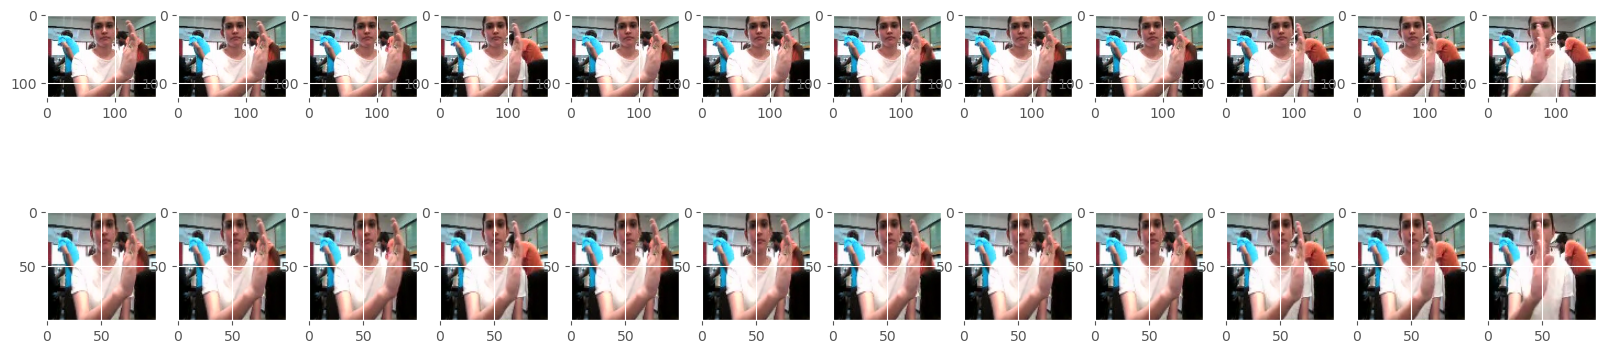

In [74]:
# Testing the generator
test_gen = generator(train_path, train_doc, 1, debug = True)
batch_data, batch_labels=next(test_gen)

In [75]:
print('The number of classes the videos can be classified into:',batch_labels.size)

The number of classes the videos can be classified into: 5


In [106]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = epochs # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


# Visualization After Training the Model

### Plots: Wrapper functions to Visualize the trained model for validation loss and accuracy metrics

In [107]:
# function to plot the training/validation accuracies/losses.

def plot(trained_model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(trained_model.history['loss'])   
    axes[0].plot(trained_model.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[0].plot(np.argmin(trained_model.history["val_loss"]),np.min(trained_model.history["val_loss"]),marker="x", color="r",label="best model")
    plt.figure(figsize=(8,8))

    axes[1].plot(trained_model.history['categorical_accuracy'])   
    axes[1].plot(trained_model.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    # Find the epoch with the lowest validation loss
    best_epoch = trained_model.history['val_loss'].index(min(trained_model.history['val_loss'])) + 1
    best_val_loss = min(trained_model.history['val_loss'])
    best_val_accuracy = trained_model.history['val_categorical_accuracy'][best_epoch - 1]
    corres_train_accuracy = trained_model.history['categorical_accuracy'][best_epoch - 1]

    print(f"Best Model - Epoch: {best_epoch}, Validation Loss: {best_val_loss}, Validation Accuracy: {best_val_accuracy}, Training Accuracy: {corres_train_accuracy}")

# Model Building - Conv3D - Base Model
### 1. Base Model Definition

In [74]:
def Model_design(sample_size):

    # Create model
    model = Sequential()
    model.add(Conv3D(filters = 32,
                     kernel_size = (3, 3, 3),
                     kernel_initializer = 'he_uniform',
                     padding = 'same',
                     input_shape = sample_size))
    model.add(MaxPooling3D((2,2,2)))
    model.add(Dropout(0.1))

    model.add(Conv3D(filters = 64,
                     kernel_size = (3, 3, 3),
                     kernel_initializer = 'he_uniform',
                     padding = 'same'))
    model.add(MaxPooling3D((2,2,2)))
    model.add(Dropout(0.1))
    
    model.add(Conv3D(filters = 128,
                     kernel_size = (3, 3, 3),
                     kernel_initializer = 'he_uniform',
                     padding = 'same'))
    model.add(MaxPooling3D((2,2,2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(64, activation='relu', kernel_initializer = 'he_uniform'))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimiser = Adam() #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

### 2. Instantiate the model

In [79]:
# Instantiate the model
model = Model_design(sample_size)

### 3. Statistics of Base Model

In [80]:
# Statistics of Base Model
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 12, 100, 100, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 6, 50, 50, 32)     0         
 ng3D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 6, 50, 50, 32)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 6, 50, 50, 64)     55360     
                                                                 
 max_pooling3d_13 (MaxPooli  (None, 3, 25, 25, 64)     0         
 ng3D)                                                           
                                                      

### 4. Generate datapoints for training and test

In [39]:
# Generate datapoints for training and test
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### 5. File Creation for Saving Best Model

In [40]:
# Create file to put the best model in
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(factor = 0.1, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

### 6. Calculate Parameters to Fit the Model

In [41]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 7. Fit data to Model

In [84]:
# Fit data to the model

results = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/4s/jwcqmfxx0sn21fklt1l7kj0c0000gn/T/ipykernel_1891/2312752288.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 25
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 7.6828 - categorical_accuracy: 0.2021Source path =  Project_data/val ; batch size = 25

Epoch 1: val_loss improved from inf to 5.51244, saving model to model_init_2024-03-2414_40_21.007218/model-00001-7.68279-0.20211-5.51244-0.23000.h5
27/27 [==============================] - 268s 10s/step - loss: 7.6828 - categorical_accuracy: 0.2021 - val_loss: 5.5124 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20


/Applications/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 1.5517 - categorical_accuracy: 0.3047
Epoch 2: val_loss improved from 5.51244 to 4.71215, saving model to model_init_2024-03-2414_40_21.007218/model-00002-1.55174-0.30468-4.71215-0.26000.h5
27/27 [==============================] - 256s 10s/step - loss: 1.5517 - categorical_accuracy: 0.3047 - val_loss: 4.7122 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.3946 - categorical_accuracy: 0.3831
Epoch 3: val_loss improved from 4.71215 to 3.31786, saving model to model_init_2024-03-2414_40_21.007218/model-00003-1.39460-0.38311-3.31786-0.31000.h5
27/27 [==============================] - 267s 10s/step - loss: 1.3946 - categorical_accuracy: 0.3831 - val_loss: 3.3179 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 1.2042 - categorical_accuracy: 0.5008
Epoch 4: val_loss improved from 3.31786 to 2.55440, s

### 8. Plot Metrics to Analyse Model Performance

Best Model - Epoch: 20, Validation Loss: 1.4118411540985107, Validation Accuracy: 0.6399999856948853, Training Accuracy: 1.0


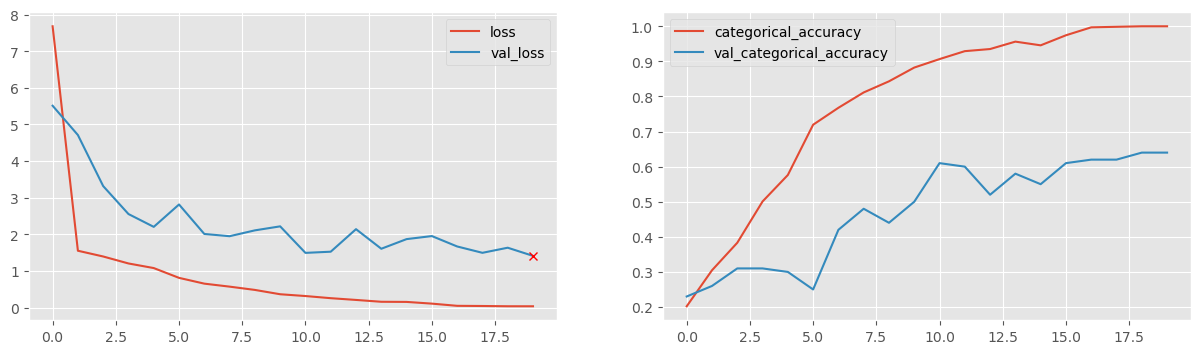

<Figure size 800x800 with 0 Axes>

In [86]:
plot(results)

### 9. Analysis of Base Model

- The model is learning gradually which is a good sign.
- Towards the end, the model is overfitting. We will perform some experiments next to reduce overfit and validation loss. This in turn will improve the accuracy of the model.
- Tabulated Metrics:
| Metric | Value |
| --- | --- | 
| Best Model | Epoch 20 |
| Validation Loss | 1.42 |
| Training Accuracy | 1.0 |
| Validation Accuracy | 0.64 |

# Experiment #1 - Decrease Number of Frames in img_idx
## Set count by 3 to select frames
### 1. Re-instantiate hyperparameters and reuse Base Model

In [91]:
batch_size = 25
# Select frames by skipping by 3 from 5 to 28.
seq_idx = range(5,28,3)
epochs = 20
sample_size = (len(seq_idx), dim_x, dim_y, 3)

### 2. Instantiate the model

In [98]:
# Instantiate the model
model1 = Model_design(sample_size)

### 3. Statistics of model

In [99]:
print (model1.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 8, 100, 100, 32)   2624      
                                                                 
 max_pooling3d_18 (MaxPooli  (None, 4, 50, 50, 32)     0         
 ng3D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 4, 50, 50, 32)     0         
                                                                 
 conv3d_19 (Conv3D)          (None, 4, 50, 50, 64)     55360     
                                                                 
 max_pooling3d_19 (MaxPooli  (None, 2, 25, 25, 64)     0         
 ng3D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 2, 25, 25, 64)    

### 4. Generate datapoints for training and test

In [100]:
# Generate datapoints for training and test
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### 5. File Creation for Saving Best Model

In [101]:
# Create file to put the best model in
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(factor = 0.1, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

### 6. Calculate Parameters to Fit the Model

In [102]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 7. Fit Data to Model

In [103]:
# Fit data to the model

results1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/4s/jwcqmfxx0sn21fklt1l7kj0c0000gn/T/ipykernel_1891/3926368600.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 25
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 6.7880 - categorical_accuracy: 0.1916Source path =  Project_data/val ; batch size = 25

Epoch 1: val_loss improved from inf to 1.80512, saving model to model_init_2024-03-2416_03_46.885920/model-00001-6.78803-0.19155-1.80512-0.23000.h5
27/27 [==============================] - 175s 7s/step - loss: 6.7880 - categorical_accuracy: 0.1916 - val_loss: 1.8051 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20


/Applications/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 1.6156 - categorical_accuracy: 0.2066
Epoch 2: val_loss did not improve from 1.80512
27/27 [==============================] - 166s 6s/step - loss: 1.6156 - categorical_accuracy: 0.2066 - val_loss: 2.1593 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.5815 - categorical_accuracy: 0.2217
Epoch 3: val_loss improved from 1.80512 to 1.61019, saving model to model_init_2024-03-2416_03_46.885920/model-00003-1.58148-0.22172-1.61019-0.26000.h5
27/27 [==============================] - 173s 6s/step - loss: 1.5815 - categorical_accuracy: 0.2217 - val_loss: 1.6102 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 1.5669 - categorical_accuracy: 0.2685
Epoch 4: val_loss did not improve from 1.61019
27/27 [==============================] - 153s 6s/step - loss: 1.5669 - categorical_accuracy: 0.2685 - val_loss: 1

### 8. Plot Metrics to Analyse Model Performance

Best Model - Epoch: 20, Validation Loss: 0.8127384781837463, Validation Accuracy: 0.6899999976158142, Training Accuracy: 0.8717948794364929


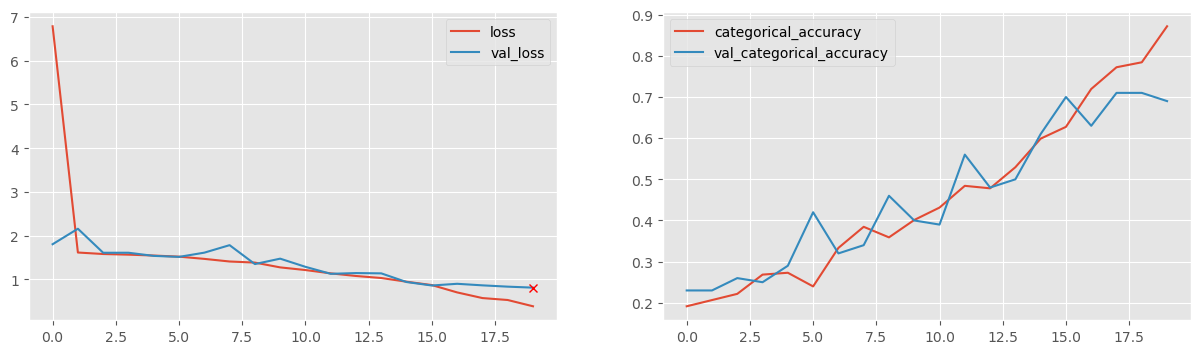

<Figure size 800x800 with 0 Axes>

In [104]:
plot(results1)

### 9. Analysis of Experiment #1
- The model is improving in performance as we reduce the number of frames in the datapoint.
- The model is not overfitting and is not under performing.
- The validation loss is acceptable too.
- Tabulated Metrics:
| Metric | Value |
| --- | --- | 
| Best Model | Epoch 20 |
| Validation Loss | 0.81 |
| Training Accuracy | 0.87 |
| Validation Accuracy | 0.69 |

# Experiment #2 - Decrease Number of Batches
## Set batch size = 20
### 1. Re-instantiate hyperparameters and reuse Base Model  

In [128]:
batch_size = 20
# Select frames by skipping by 3 from 5 to 28.
seq_idx = range(5,28,3)
epochs = 20
sample_size = (len(seq_idx), dim_x, dim_y, 3)

### 2. Instantiate the model

In [20]:
# Instantiate the model
model2 = Model_design(sample_size)

### 3. Statistics of model

In [21]:
print (model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 100, 100, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 4, 50, 50, 32)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 50, 50, 32)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 50, 50, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 25, 25, 64)     0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2, 25, 25, 64)     0

### 4. Generate datapoints for training and test

In [22]:
# Generate datapoints for training and test
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### 5. File Creation for Saving Best Model

In [25]:
# Create file to put the best model in
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(factor = 0.1, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

### 6. Calculate Parameters to Fit the Model

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 7. Fit Data to Model

In [27]:
# Fit data to the model

results2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/4s/jwcqmfxx0sn21fklt1l7kj0c0000gn/T/ipykernel_25931/2886731728.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 5.9388 - categorical_accuracy: 0.2142Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.60922, saving model to model_init_2024-03-2419_21_49.693999/model-00001-5.93880-0.21418-1.60922-0.21000.h5
34/34 [==============================] - 139s 4s/step - loss: 5.9388 - categorical_accuracy: 0.2142 - val_loss: 1.6092 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20


/Applications/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - ETA: 0s - loss: 1.6237 - categorical_accuracy: 0.2217
Epoch 2: val_loss improved from 1.60922 to 1.60855, saving model to model_init_2024-03-2419_21_49.693999/model-00002-1.62372-0.22172-1.60855-0.25000.h5
34/34 [==============================] - 165s 5s/step - loss: 1.6237 - categorical_accuracy: 0.2217 - val_loss: 1.6085 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.2097
Epoch 3: val_loss did not improve from 1.60855
34/34 [==============================] - 174s 5s/step - loss: 1.6092 - categorical_accuracy: 0.2097 - val_loss: 1.6089 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.2081
Epoch 4: val_loss did not improve from 1.60855
34/34 [==============================] - 183s 5s/step - loss: 1.6092 - categorical_accuracy: 0.2081 - val_loss: 1

### 8. Plot Metrics to Analyse Model Performance

Best Model - Epoch: 15, Validation Loss: 1.6053264141082764, Validation Accuracy: 0.1899999976158142, Training Accuracy: 0.19909502565860748


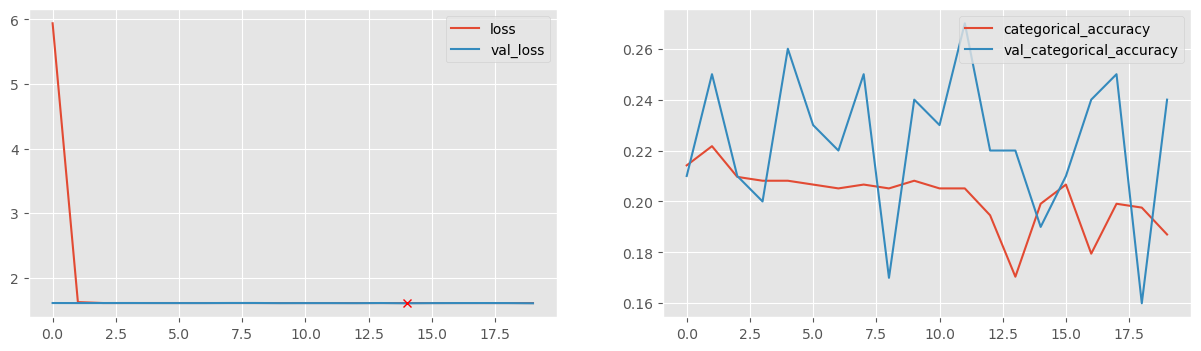

<Figure size 800x800 with 0 Axes>

In [28]:
plot(results2)

### 9. Analysis of Experiment #2
- The model is not learning well when batch size is further decreased.
- It is not wise to reduce batch_size below 25
- Tabulated Metrics:
| Metric | Value |
| --- | --- | 
| Best Model | Epoch 15 |
| Validation Loss | 1.6 |
| Training Accuracy | 0.19 |
| Validation Accuracy | 0.19 |

# Experiment #3 - Decrease image size
## Set image_size = 80 x 80
### 1. Re-instantiate frame parameters, hyperparameters and reuse Base Model

In [29]:
# Initialize frame properties    
dim_x = 80
dim_y = 80
channels = 3 #RGB frames
num_classes = 5
total_frames = 30

#Initialize hyperparameters
batch_size = 30
# Select frames by skipping by 3 from 5 to 28.
seq_idx = range(5,28,3)
epochs = 20
sample_size = (len(seq_idx), dim_x, dim_y, 3)

### 2. Instantiate the model

In [37]:
# Instantiate the model
model4 = Model_design(sample_size)

### 3. Statistics of model

In [38]:
print (model4.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 8, 80, 80, 32)     2624      
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 4, 40, 40, 32)     0         
 g3D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 4, 40, 40, 32)     0         
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 40, 40, 64)     55360     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 2, 20, 20, 64)     0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 2, 20, 20, 64)    

### 4. Generate datapoints for training and test

In [149]:
# Generate datapoints for training and test
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### 5. File Creation for Saving Best Model

In [150]:
# Create file to put the best model in
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(factor = 0.1, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

### 6. Calculate Parameters to Fit the Model

In [151]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 7. Fit Data to Model

In [42]:
# Fit data to the model

results4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/4s/jwcqmfxx0sn21fklt1l7kj0c0000gn/T/ipykernel_25931/2735216795.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 3.9808 - categorical_accuracy: 0.1991Source path =  Project_data/val ; batch size = 30

Epoch 1: val_loss improved from inf to 2.19469, saving model to model_init_2024-03-2419_21_49.693999/model-00001-3.98077-0.19910-2.19469-0.20000.h5
23/23 [==============================] - 100s 4s/step - loss: 3.9808 - categorical_accuracy: 0.1991 - val_loss: 2.1947 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20


/Applications/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - ETA: 0s - loss: 1.5974 - categorical_accuracy: 0.2594
Epoch 2: val_loss improved from 2.19469 to 1.51612, saving model to model_init_2024-03-2419_21_49.693999/model-00002-1.59740-0.25943-1.51612-0.36000.h5
23/23 [==============================] - 104s 5s/step - loss: 1.5974 - categorical_accuracy: 0.2594 - val_loss: 1.5161 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.4961 - categorical_accuracy: 0.3363
Epoch 3: val_loss improved from 1.51612 to 1.49945, saving model to model_init_2024-03-2419_21_49.693999/model-00003-1.49606-0.33635-1.49945-0.23000.h5
23/23 [==============================] - 101s 4s/step - loss: 1.4961 - categorical_accuracy: 0.3363 - val_loss: 1.4995 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 4/20
23/23 [==============================] - ETA: 0s - loss: 1.4179 - categorical_accuracy: 0.3605
Epoch 4: val_loss did not improve from 1.49945
23/23 [=

### 8. Plot Metrics to Analyse Model Performance

Best Model - Epoch: 18, Validation Loss: 0.8741744160652161, Validation Accuracy: 0.75, Training Accuracy: 0.9683257937431335


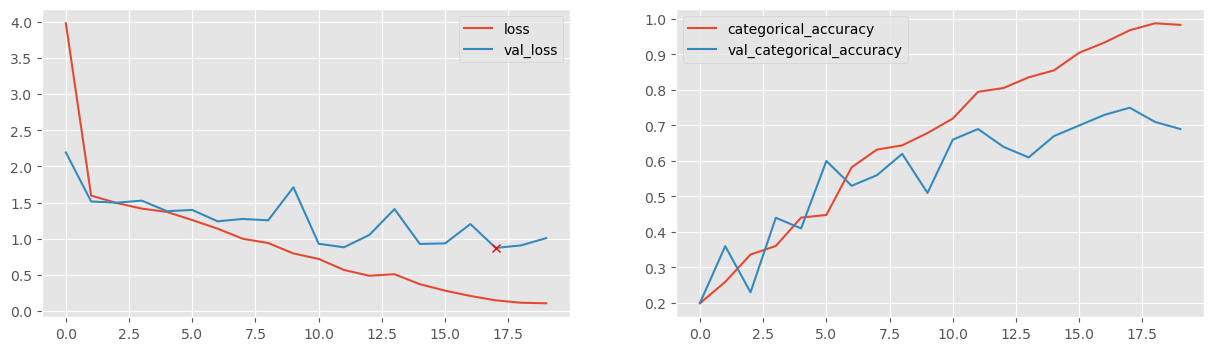

<Figure size 800x800 with 0 Axes>

In [43]:
plot(results4)

### 9. Analysis of Experiment #3
- The model is the best so far with very good validation accuracy.
- Reducing the image size to 80x80 has helped learn the features better.
- Tabulated Metrics:
| Metric | Value |
| --- | --- | 
| Best Model | Epoch 18 |
| Validation Loss | 0.87 |
| Training Accuracy | 0.96 |
| Validation Accuracy | 0.75 |

# Experiment #4 - Reduce Image Size, Epochs
## Set image size = 60 x 60, epochs = 15
### 1. Re-instantiate hyperparameters and reuse Base Model

In [70]:
# Initialize frame properties    
dim_x = 60
dim_y = 60
channels = 3 #RGB frames
num_classes = 5
total_frames = 30

#Initialize hyperparameters
batch_size = 30
# Select frames by skipping by 3 from 5 to 28.
seq_idx = range(5,28,3)
epochs = 15
sample_size = (len(seq_idx), dim_x, dim_y, 3)

### 2. Instantiate the model

In [75]:
# Instantiate the model
model6 = Model_design(sample_size)

### 3. Statistics of model

In [76]:
print (model6.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 32)     2624      
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 4, 30, 30, 32)     0         
 g3D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 4, 30, 30, 32)     0         
                                                                 
 conv3d_10 (Conv3D)          (None, 4, 30, 30, 64)     55360     
                                                                 
 max_pooling3d_10 (MaxPooli  (None, 2, 15, 15, 64)     0         
 ng3D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 2, 15, 15, 64)    

### 4. Generate datapoints for training and test

In [77]:
# Generate datapoints for training and test
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### 5. File Creation for Saving Best Model

In [78]:
# Create file to put the best model in
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(factor = 0.1, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

### 6. Calculate Parameters to Fit the Model

In [79]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 7. Fit Data to Model

In [80]:
# Fit data to the model

results6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/4s/jwcqmfxx0sn21fklt1l7kj0c0000gn/T/ipykernel_25931/2116851704.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.5410 - categorical_accuracy: 0.2760Source path =  Project_data/val ; batch size = 30

Epoch 1: val_loss improved from inf to 1.96247, saving model to model_init_2024-03-2421_24_00.543858/model-00001-2.54102-0.27602-1.96247-0.33000.h5
23/23 [==============================] - 102s 5s/step - loss: 2.5410 - categorical_accuracy: 0.2760 - val_loss: 1.9625 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/15


/Applications/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - ETA: 0s - loss: 1.5914 - categorical_accuracy: 0.2609
Epoch 2: val_loss improved from 1.96247 to 1.46232, saving model to model_init_2024-03-2421_24_00.543858/model-00002-1.59141-0.26094-1.46232-0.31000.h5
23/23 [==============================] - 89s 4s/step - loss: 1.5914 - categorical_accuracy: 0.2609 - val_loss: 1.4623 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.3695 - categorical_accuracy: 0.4133
Epoch 3: val_loss improved from 1.46232 to 1.23665, saving model to model_init_2024-03-2421_24_00.543858/model-00003-1.36952-0.41327-1.23665-0.54000.h5
23/23 [==============================] - 86s 4s/step - loss: 1.3695 - categorical_accuracy: 0.4133 - val_loss: 1.2366 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 4/15
23/23 [==============================] - ETA: 0s - loss: 1.1413 - categorical_accuracy: 0.5581
Epoch 4: val_loss improved from 1.23665 to 1.09043, savin

### 8. Plot Metrics to Analyse Model Performance

Best Model - Epoch: 13, Validation Loss: 0.828091025352478, Validation Accuracy: 0.7300000190734863, Training Accuracy: 0.8974359035491943


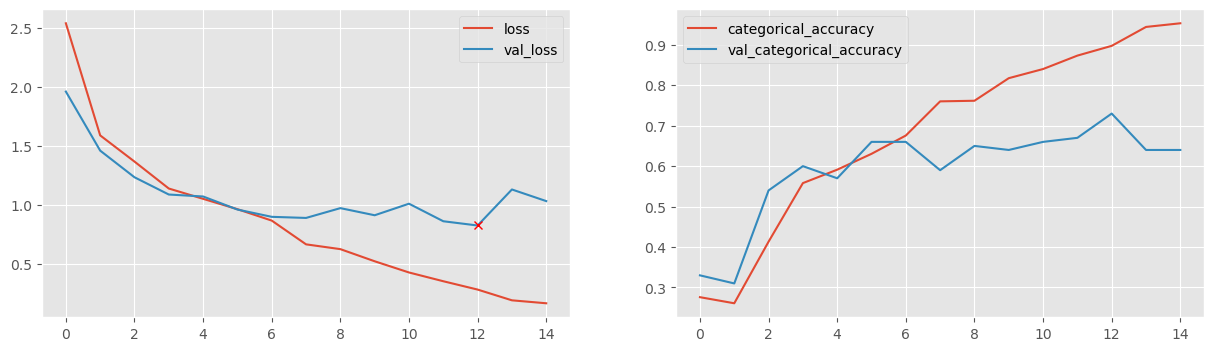

<Figure size 800x800 with 0 Axes>

In [81]:
plot(results6)

### 9. Analysis of Experiment #4
- The model is very good with good validation accuracy and minimal loss.
- Reducing the image size to 60x60 has helped learn the features better.
- Reducing epochs to 15 has helped avoid overfitting.
- This model is the best in terms of balancing both accuracy and validation loss.
- Also, this is the model with the least parameters in all the experiments that has done well.
- This model also runs on lesser epochs making it more performant and resource efficient.
- Tabulated Metrics:
| Metric | Value |
| --- | --- | 
| Best Model | Epoch 13 |
| Validation Loss | 0.82 |
| Training Accuracy | 0.89 |
| Validation Accuracy | 0.73 |

# Experiment #5 - Adjusting architecture
## Add more layers, dropout, batch normlaization
### 1. Re-instantiate hyperparameters and build new model

In [101]:
# Initialize frame properties    
dim_x = 60
dim_y = 60
channels = 3 #RGB frames
num_classes = 5
total_frames = 30

#Initialize hyperparameters
batch_size = 30
# Select frames by skipping by 3 from 5 to 28.
seq_idx = range(5,28,3)
epochs = 15
sample_size = (len(seq_idx), dim_x, dim_y, 3)

In [108]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense, BatchNormalization
#from tensorflow.keras.optimizers import Adam


def Model_design_1(sample_size):
 
    # Create model

    model = Sequential()

    model.add(Conv3D(filters = 16,

                     kernel_size = (3, 3, 3),

                     kernel_initializer = 'he_uniform',

                     padding = 'same',

                     input_shape = sample_size))

    model.add(MaxPooling3D((2,2,2)))

    model.add(BatchNormalization())

    model.add(Dropout(0.1))

    model.add(Conv3D(filters = 32,

                     kernel_size = (3, 3, 3),

                     kernel_initializer = 'he_uniform',

                     padding = 'same',

                     input_shape = sample_size))

    model.add(MaxPooling3D((2,2,2)))

    model.add(BatchNormalization())

    model.add(Dropout(0.1))

    model.add(Conv3D(filters = 64,

                     kernel_size = (3, 3, 3),

                     kernel_initializer = 'he_uniform',

                     padding = 'same',

                     input_shape = sample_size))

    model.add(MaxPooling3D((2,2,2)))

    model.add(BatchNormalization())

    model.add(Dropout(0.1))

    model.add(Flatten())
 
    model.add(Dense(64, activation='relu', kernel_initializer = 'he_uniform'))

    model.add(Dense(num_classes, activation='softmax'))

    optimiser = Adam() #write your optimizer

    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

### 2. Instantiate new model

In [109]:
# Instantiate the model
model7 = Model_design_1(sample_size)

### 3. Statistics of model

In [110]:
print (model7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 8, 60, 60, 16)     1312      
                                                                 
 max_pooling3d_18 (MaxPooli  (None, 4, 30, 30, 16)     0         
 ng3D)                                                           
                                                                 
 batch_normalization_6 (Bat  (None, 4, 30, 30, 16)     64        
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 4, 30, 30, 16)     0         
                                                                 
 conv3d_19 (Conv3D)          (None, 4, 30, 30, 32)     13856     
                                                                 
 max_pooling3d_19 (MaxPooli  (None, 2, 15, 15, 32)    

### 4. Generate datapoints for training and test

In [111]:
# Generate datapoints for training and test
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

### 5. File Creation for Saving Best Model

In [112]:
# Create file to put the best model in
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(factor = 0.1, patience=5, min_lr=0.00001, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

### 6. Calculate Parameters to Fit the Model

In [113]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 7. Fit Data to Model¶

In [114]:
# Fit data to the model

results7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/4s/jwcqmfxx0sn21fklt1l7kj0c0000gn/T/ipykernel_25931/3364280904.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1,


Source path =  Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.5173 - categorical_accuracy: 0.4630Source path =  Project_data/val ; batch size = 30

Epoch 1: val_loss improved from inf to 7.83799, saving model to model_init_2024-03-2422_22_36.226614/model-00001-1.51734-0.46305-7.83799-0.20000.h5
23/23 [==============================] - 95s 4s/step - loss: 1.5173 - categorical_accuracy: 0.4630 - val_loss: 7.8380 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/15


/Applications/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - ETA: 0s - loss: 0.7553 - categorical_accuracy: 0.7044
Epoch 2: val_loss improved from 7.83799 to 3.75061, saving model to model_init_2024-03-2422_22_36.226614/model-00002-0.75530-0.70437-3.75061-0.30000.h5
23/23 [==============================] - 86s 4s/step - loss: 0.7553 - categorical_accuracy: 0.7044 - val_loss: 3.7506 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 0.4846 - categorical_accuracy: 0.8205
Epoch 3: val_loss improved from 3.75061 to 1.42233, saving model to model_init_2024-03-2422_22_36.226614/model-00003-0.48461-0.82051-1.42233-0.43000.h5
23/23 [==============================] - 70s 3s/step - loss: 0.4846 - categorical_accuracy: 0.8205 - val_loss: 1.4223 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 4/15
23/23 [==============================] - ETA: 0s - loss: 0.2676 - categorical_accuracy: 0.9140
Epoch 4: val_loss improved from 1.42233 to 1.24952, savin

### 8. Plot Metrics to Analyse Model Performance

Best Model - Epoch: 6, Validation Loss: 1.127734661102295, Validation Accuracy: 0.6299999952316284, Training Accuracy: 0.9622926115989685


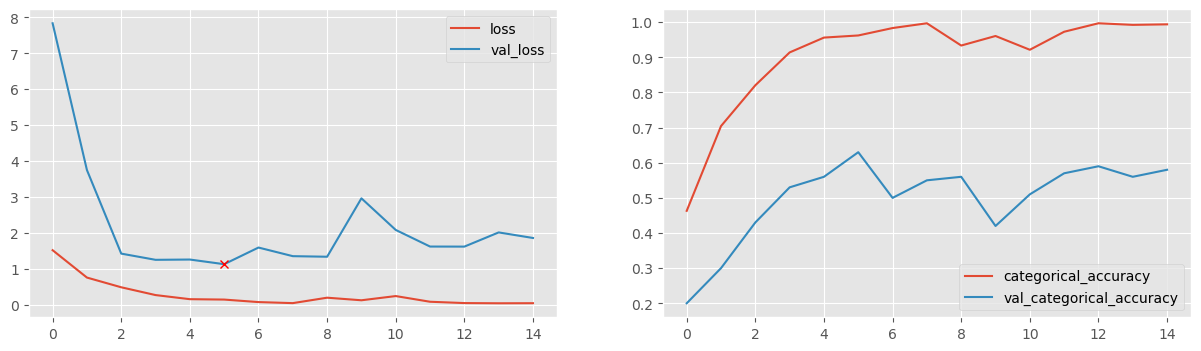

<Figure size 800x800 with 0 Axes>

In [115]:
plot(results7)

### 9. Analysis of Experiment #5
- The model is going towards overfitting.
- The lesser number of epochs helped prevent overfitting.
- Decent learning but not very good.

- Tabulated Metrics:
| Metric | Value |
| --- | --- | 
| Best Model | Epoch 6 |
| Validation Loss | 1.21 |
| Training Accuracy | 0.96 |
| Validation Accuracy | 0.62 |

# Conclusion
After all the experments we have concluded that `Experiment #4` - our base model with the following parameters works best:
- Batch size = 30
- Epochs = 15
- Image size = 60 x 60
- No. of frames = 8

- The balance between validation loss and accuracy has been the best here.
- This model has used relatively less parameters and gives very good results.

The following were the results:

| Metric | Value |
| --- | --- | 
| Best Model | Epoch 13 |
| Validation Loss | 0.82 |
| Training Accuracy | 0.89 |
| Validation Accuracy | 0.73 |
| Trainable parameters | 681093 |

- Model created: `model-00013-0.28534-0.89744-0.82809-0.73000.h5`